<img style="float: right; margin: 0px 0px 15px 15px;" src="https://wallpaperaccess.com/full/7006038.jpg" width="350px" height="300" />

# Book clasification

+ Ana Rosaura Zamarrón Álvarez - 736222
+ Claudia Celeste Castillejos Jáuregui - 735868

## Introducción
Hoy en día los sistemas de recomendación son parte de la vida cotidiana de gran parte de las personas, lo podemos ver en muchos sitios de internet como las redes sociales, sitios de E-Commerce como Amazon o Mercado Libre, o algúna plataforma de streaming como Netflix o Spotify. Los sistemas de recomendación afectan significativamente en el contenido que consumimos diariamente, por eso es importante que un científico de datos aprenda a utilizaros, tienen un valor significativo para muchas empresas o proyectos.

Para este proyecto se creará un sistema de recomendación donde los productos a recomendar son libros. Es un tema interesante porque dentro del mundo de los sistemas de recomendación los productos a tratar normalmente son películas, productos de una tienda departamental, canciones, etc.; pero no hay muchos ejemplos sobre libros.

El modelo se desplegará en un API donde el usuario podrá hacer la petición para recibir una recomendación de un libro con base en otro que ya leyó. El dataset contiene ratings de 278,858 usuarios que proveen 1,149,780 ratings (explicito / implicito) de alrededor de 271,379 libros.

Los datos se obtuvieron de Kaggle: https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset.


## Antecedentes
Para crear nuestro sistema de recomendación se utilizará un filtrado colaborativo basado en items. Este algoritmo calcula la similitud que hay entre los productos utilizando los ratings que le dieron los usuarios a cada uno y recomienda el producto más similar a los que ya consumió el usuario. Amazon desarrolló el filtrado colaborativo basado en items. En un sistema donde hay más usuarios que elementos, el filtrado basado en items es más rápido y más estable que el basado en usuarios. Es efectivo porque, por lo general, la calificación promedio que recibe un item no cambia tan rápido como la calificación promedio otorgada por un usuario a diferentes items.

## Objetivos
+ Crear un sistema de recomendación de libros utilizando el algoritmo de filtrado colaborativo
+ Hacer un despliegue del modelo utilizando un API.

## Planteamineto del problema
El producto final del proyecto será un programa que sea capaz de recomendar un libro a un usuario. El API que se creará debe ser capaz de recibir información del usuario, puede ser uno o varios libros que le hayan gustado, pero solo pueden ser libros que estén en nuestra base de datos.

In [2]:
# Librerías
import matplotlib.pyplot as plt
import pandas as pd
from surprise import Reader
from surprise import Dataset
import plotly.express as px
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise import accuracy
from langdetect import detect
import time
import numpy as np

## Exploratory Data Analysis

In [2]:
ratings = pd.read_csv("./archive/Book reviews/Book reviews/BX-Book-Ratings.csv",
                   encoding="latin",
                   sep=';',
                   dtype={"User-ID":str, "ISBN":str, "Book-Rating":int})

books = pd.read_csv("./archive/Book reviews/Book reviews/BX_Books.csv",
                    encoding="latin",
                    sep=";",
                    dtype={"ISBN":str})

users = pd.read_csv("./archive/Book reviews/Book reviews/BX-Users.csv",
                    encoding="latin",
                    sep=";",
                    dtype={"User-ID":str, "Age":float})

In [3]:
books.shape

(271379, 8)

In [4]:
books[books["Book-Title"] == "253"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1905,0006550789,253,Geoff Ryman,0,Flamingo,http://images.amazon.com/images/P/0006550789.0...,http://images.amazon.com/images/P/0006550789.0...,http://images.amazon.com/images/P/0006550789.0...


In [5]:
books = books[(books["Book-Title"] != "1984") & (books["Book-Title"] != "253") & (books["Book-Title"] != "24/7")]
books.shape

(271367, 8)

In [6]:
books = books[books["Book-Title"].str.contains("Ã") == False]
books = books[books["Book-Title"].str.contains("r'\?.*'") == False]
books = books[books["Book-Title"].str.contains("@") == False]
books = books[books["Book-Title"].str.contains("¶") == False]
books = books[books["Book-Title"].str.contains("'") == False]
books = books[books["Book-Title"].str.contains("1") == False]
books = books[books["Book-Title"].str.contains("2") == False]
books = books[books["Book-Title"].str.contains("3") == False]
books = books[books["Book-Title"].str.contains("4") == False]
books = books[books["Book-Title"].str.contains("5") == False]
books = books[books["Book-Title"].str.contains("6") == False]
books = books[books["Book-Title"].str.contains("7") == False]
books = books[books["Book-Title"].str.contains("8") == False]
books = books[books["Book-Title"].str.contains("9") == False]
books = books[books["Book-Title"].str.isnumeric() == False]
books = books.reset_index(drop=True)
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
4,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...
...,...,...,...,...,...,...,...,...
202411,1845170423,Cocktail Classics,David Biggs,2004,Connaught,http://images.amazon.com/images/P/1845170423.0...,http://images.amazon.com/images/P/1845170423.0...,http://images.amazon.com/images/P/1845170423.0...
202412,014002803X,Anti Death League,Kingsley Amis,1975,Viking Press,http://images.amazon.com/images/P/014002803X.0...,http://images.amazon.com/images/P/014002803X.0...,http://images.amazon.com/images/P/014002803X.0...
202413,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright,1993,Ballantine Books,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...
202414,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...


In [7]:
unique_books = books[["Book-Title"]].drop_duplicates(["Book-Title"])
unique_books

,Book-Title
0,Classical Mythology
1,Clara Callan
2,Decision in Normandy
3,The Mummies of Urumchi
4,PLEADING GUILTY
...,...
202411,Cocktail Classics
202412,Anti Death League
202413,Flashpoints: Promise and Peril in a New World
202414,From One to One Hundred


In [8]:
inicio = time.time()
unique_books['Language'] = unique_books['Book-Title'].apply(detect)
unique_books.head()
final= time.time()
print(final-inicio) # https://stackoverflow.com/questions/43916600/text-language-detection-in-python

3541.870498895645


In [10]:
print((final-inicio)/60)

59.031174981594084


In [ ]:
unique_books

In [11]:
books2 = books.merge(unique_books, on="Book-Title")
books2

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,en
1,0801319536,Classical Mythology,Mark P. O. Morford,1998,John Wiley & Sons,http://images.amazon.com/images/P/0801319536.0...,http://images.amazon.com/images/P/0801319536.0...,http://images.amazon.com/images/P/0801319536.0...,en
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,it
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,en
...,...,...,...,...,...,...,...,...,...
202411,1845170423,Cocktail Classics,David Biggs,2004,Connaught,http://images.amazon.com/images/P/1845170423.0...,http://images.amazon.com/images/P/1845170423.0...,http://images.amazon.com/images/P/1845170423.0...,en
202412,014002803X,Anti Death League,Kingsley Amis,1975,Viking Press,http://images.amazon.com/images/P/014002803X.0...,http://images.amazon.com/images/P/014002803X.0...,http://images.amazon.com/images/P/014002803X.0...,en
202413,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright,1993,Ballantine Books,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,en
202414,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,en


In [12]:
books2.to_parquet("book_languages.parquet.gzip", compression='gzip')

In [13]:
books2["Language"].value_counts()

en    153411
de     14570
es      3772
fr      3719
nl      2774
it      2414
af      2260
tl      2228
no      1706
id      1676
ca      1660
da      1529
pt      1418
ro      1289
cy       961
so       933
sv       828
et       815
sw       650
fi       617
vi       562
pl       531
tr       502
lt       363
sl       289
hu       283
hr       247
sq       144
sk       105
cs        86
lv        74
Name: Language, dtype: int64

Text(0.5, 1.0, 'Histograma de distribución de ratings')

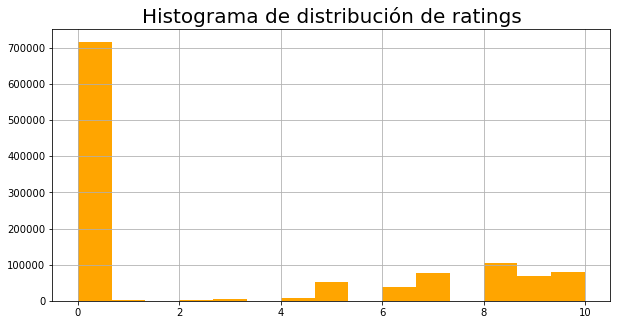

In [15]:
plt.figure(figsize=(10,5))
ratings["Book-Rating"].hist(bins=15, color="orange")
plt.title("Histograma de distribución de ratings", fontsize=20)

In [16]:
ratings["Book-Rating"].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

El rating más frecuente es de 0.

In [32]:
# Unión de los 3 dataframes
data = ratings.merge(books2, on=["ISBN"], how="inner")
data = data.merge(users, on=["User-ID"], how="left")
data.head(10)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Language,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"cincinnati, ohio, usa",23.0
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"strafford, missouri, usa",34.0
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"st. charles county, missouri, usa",2.0
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"beaverton, oregon, usa",NaN
5,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"st. louis, missouri, usa",45.0
6,28266,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"portland, oregon, usa",NaN
7,28523,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"springfield, missouri, usa",24.0
8,39002,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"san jose, ,",NaN
9,50403,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,en,"conway, arkansas, usa",NaN


In [33]:
data.shape

(809765, 13)

In [34]:
data.isna().sum()

User-ID                     0
ISBN                        0
Book-Rating                 0
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
Image-URL-M                 0
Image-URL-L                 0
Language                    0
Location                    0
Age                    221625
dtype: int64

In [19]:
len(data["User-ID"].unique()), len(data["ISBN"].unique())

(105283, 340556)

En total hay 105,283 usuarios y 340,556 libros.

In [35]:
data.dtypes

User-ID                 object
ISBN                    object
Book-Rating              int64
Book-Title              object
Book-Author             object
Year-Of-Publication      int64
Publisher               object
Image-URL-S             object
Image-URL-M             object
Image-URL-L             object
Language                object
Location                object
Age                    float64
dtype: object

Tenemos 9 variables de tipo objeto, y 3 variables numéricas.

In [36]:
data.describe()

,Book-Rating,Year-Of-Publication,Age
count,809765.000000,809765.000000,588140.000000
mean,2.846502,1962.810408,37.655179
std,3.851837,252.371774,14.149057
min,0.000000,0.000000,0.000000
25%,0.000000,1991.000000,28.000000
50%,0.000000,1997.000000,35.000000
75%,7.000000,2001.000000,46.000000
max,10.000000,2050.000000,244.000000


#### Age

In [37]:
data[data["Age"] > 100]

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Language,Location,Age
188,13273,038550120X,0,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,en,"harrisburg, pennsylvania, usa",201.0
590,226616,0449006522,0,Manhattan Hunt Club,JOHN SAUL,2002,Ballantine Books,http://images.amazon.com/images/P/0449006522.0...,http://images.amazon.com/images/P/0449006522.0...,http://images.amazon.com/images/P/0449006522.0...,en,"tucson, arizona, usa",204.0
639,52472,0553561618,8,Dark Paradise,TAMI HOAG,1994,Bantam,http://images.amazon.com/images/P/0553561618.0...,http://images.amazon.com/images/P/0553561618.0...,http://images.amazon.com/images/P/0553561618.0...,id,"frisco/dallas, texas, usa",209.0
778,52472,055356451X,0,Night Sins,TAMI HOAG,1995,Bantam,http://images.amazon.com/images/P/055356451X.0...,http://images.amazon.com/images/P/055356451X.0...,http://images.amazon.com/images/P/055356451X.0...,de,"frisco/dallas, texas, usa",209.0
1003,13273,0451192001,0,How Stella Got Her Groove Back,Terry McMillan,1997,Signet Book,http://images.amazon.com/images/P/0451192001.0...,http://images.amazon.com/images/P/0451192001.0...,http://images.amazon.com/images/P/0451192001.0...,en,"harrisburg, pennsylvania, usa",201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806780,267830,0929398866,8,The Viewpoints of Stanley Marcus: A Ten-Year P...,Stanley Marcus,1995,University of North Texas Press,http://images.amazon.com/images/P/0929398866.0...,http://images.amazon.com/images/P/0929398866.0...,http://images.amazon.com/images/P/0929398866.0...,en,"fort worth, texas, usa",101.0
806781,267830,0931722179,10,Nekkid cowboy,Katie Breeze,1982,Corona Pub. Co,http://images.amazon.com/images/P/0931722179.0...,http://images.amazon.com/images/P/0931722179.0...,http://images.amazon.com/images/P/0931722179.0...,pl,"fort worth, texas, usa",101.0
806782,267830,0965870707,8,Threadbear: A Story of Christian Healing for A...,Tilda Norberg,1997,Penn Haus Press,http://images.amazon.com/images/P/0965870707.0...,http://images.amazon.com/images/P/0965870707.0...,http://images.amazon.com/images/P/0965870707.0...,en,"fort worth, texas, usa",101.0
806783,267830,1559345233,8,"Frauds, Myths, and Mysteries: Science and Pseu...",Kenneth L. Feder,1996,McGraw Hill College Div,http://images.amazon.com/images/P/1559345233.0...,http://images.amazon.com/images/P/1559345233.0...,http://images.amazon.com/images/P/1559345233.0...,en,"fort worth, texas, usa",101.0


<AxesSubplot:>

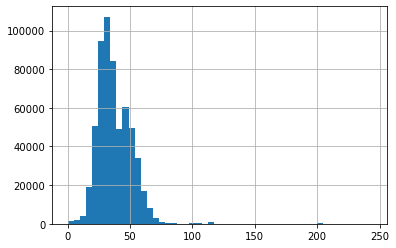

In [38]:
data["Age"].hist(bins = 50)

+ La media de ratings es de 2.83, el mínimo es de 0 y el máximo es de 10.
+ El promedio de edad de los usuarios es de 37 años. Hay 150 clientes que tienen más de 100 años, donde el máximo es de 244 años. Suponemos que hay muchos errores en esta variable. No la vamos a usar.

In [39]:
data.isna().sum()

User-ID                     0
ISBN                        0
Book-Rating                 0
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
Image-URL-M                 0
Image-URL-L                 0
Language                    0
Location                    0
Age                    221625
dtype: int64

Después de hacer la unión de los 3 datasets quedan valores nulos en algunos datos sobre los libros y los clientes. Probablemente sea mejor eliminarlos antes de hacer el modelo de sistema de recoemndación, ya que no nos sirve hacer una recomendación de un libro si no sabemos cuál es porque no sabemos cuál es el título.

#### Book title

In [40]:
data[data["Book-Rating"] == data["Book-Rating"].max()].groupby("Book-Title")["Book-Rating"].count().sort_values(ascending=False)

Book-Title
The Da Vinci Code                        160
The Lovely Bones: A Novel                148
To Kill a Mockingbird                    133
The Secret Life of Bees                  112
The Notebook                              93
                                        ... 
Jean and Johnny                            1
Je me souviens de Paris                    1
Je hais les pigeons                        1
Jazz in the Bittersweet Blues of Life      1
Â¡Corre, perro, corre!                     1
Name: Book-Rating, Length: 29521, dtype: int64

El libro con más ratings de 10 es The Da Vinci Code, tuvo calificación de 10 160 veces. Los siguientes libros mejores calificados son los de Harry Poter, The Lovely Bones, y To Kill a Mockingbird.

In [41]:
data[data["Book-Rating"] == data["Book-Rating"].min()].groupby("Book-Title")["Book-Rating"].count().sort_values(ascending=False)

Book-Title
Wild Animus                                                                                                                                                                                                        1921
The Lovely Bones: A Novel                                                                                                                                                                                           588
A Painted House                                                                                                                                                                                                     472
The Nanny Diaries: A Novel                                                                                                                                                                                          435
Divine Secrets of the Ya-Ya Sisterhood: A Novel                                                                              

El libro con peor calificación (de uno) fue Wild Animus, seguido de The Loveley Bones. Curiosamente este libro también es de los mejores calificados, seguramente sucede porque may muchos más datos de este libro que del resto.

#### Author

In [42]:
books["Book-Author"].value_counts()

Agatha Christie             529
William Shakespeare         455
Stephen King                400
Charles Dickens             250
Isaac Asimov                244
                           ... 
Norma Gabler                  1
JAMES C. HUMES                1
Sheilah B Bruce               1
Elizabeth M, M.D. Gallup      1
Teri Sloat                    1
Name: Book-Author, Length: 83339, dtype: int64

Los tres autores más frecuentes son Agatha Christie, William Shakespeare, y Stephen King.

#### Location

In [43]:
data["Location"].value_counts()

toronto, ontario, canada         11843
n/a, n/a, n/a                     8914
chicago, illinois, usa            7063
seattle, washington, usa          6886
olympia, washington, usa          6540
                                 ...  
powell river, ,                      1
sevrier, haute-savoie, france        1
america, limburg, netherlands        1
la crescent, minnesota, usa          1
stuttgart, \n/a\"., germany"         1
Name: Location, Length: 20678, dtype: int64

La ubicación más frecuente de los usuarios es Toronto, Canadá.

In [44]:
# Se separan los datos de la ubicación
location = data["Location"].str.split(",", expand=True)
location.rename(columns={0:"city",1:"state",2:"country"}, inplace=True)

# Se une al df original
data1 = data.join(location)

# Se agrupa por país para contar la cantidad de clientes de cada uno
country = data1.drop_duplicates("User-ID").groupby("country")["User-ID"].count().reset_index().sort_values("User-ID", ascending=False)
country.drop(0, inplace=True)
country.head(10)

,country,User-ID
354,usa,52052
59,canada,7837
118,germany,4142
343,united kingdom,3767
28,australia,2408
303,spain,2019
154,italy,1104
110,france,796
223,new zealand,610
214,netherlands,556


In [45]:
fig = px.bar(country[:20], x='country', y='User-ID', title = "Cantidad de usuarios por país")
fig.show()

La mayoría de los usuarios son de Estados Unidos, Alemania, Reino Unido, Canadá, España, o Austalia.

#### Year of publication

In [46]:
books_copy = books[books["Year-Of-Publication"] > 0]
books_vc = books_copy["Year-Of-Publication"].value_counts().reset_index().sort_values('index').reset_index(drop=True)
books_vc.rename(columns={"index":"Año de publicación", "Year-Of-Publication":"cantidad de libros"}, inplace=True)
books_vc

,Año de publicación,cantidad de libros
0,1376,1
1,1378,1
2,1900,2
3,1901,7
4,1902,1
...,...,...
104,2024,1
105,2030,6
106,2037,1
107,2038,1


In [47]:
fig = px.bar(books_vc[4:107], x='Año de publicación', y='cantidad de libros', title = "Año de publicación de 1900-2020")
fig.show()

El año de publicación de los libros más frecuente es 2002.

In [48]:
books_copy = books[books["Year-Of-Publication"] > 0]
books_copy[books_copy["Year-Of-Publication"] < 1950]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1007,3257250398,Konig Babar,Jean de Brunhoff,1920,Not Avail,http://images.amazon.com/images/P/3257250398.0...,http://images.amazon.com/images/P/3257250398.0...,http://images.amazon.com/images/P/3257250398.0...
1008,3257250053,Die Geschichte Von Babar,Jean de Brunhoff,1920,Diogenes,http://images.amazon.com/images/P/3257250053.0...,http://images.amazon.com/images/P/3257250053.0...,http://images.amazon.com/images/P/3257250053.0...
1650,0060901012,Brave New World & Brave New World Revisited,Aldous Huxley,1942,Perennial,http://images.amazon.com/images/P/0060901012.0...,http://images.amazon.com/images/P/0060901012.0...,http://images.amazon.com/images/P/0060901012.0...
3195,0340565829,Teach Yourself Furthur Spanish (Teach Yourself...,Kattan Ibarra,1920,Hodder & Stoughton,http://images.amazon.com/images/P/0340565829.0...,http://images.amazon.com/images/P/0340565829.0...,http://images.amazon.com/images/P/0340565829.0...
4735,044808919X,Disappearing Floor (Hardy Boys Mystery Stories),Franklin W. Dixon,1940,Grosset & Dunlap,http://images.amazon.com/images/P/044808919X.0...,http://images.amazon.com/images/P/044808919X.0...,http://images.amazon.com/images/P/044808919X.0...
...,...,...,...,...,...,...,...,...
196627,9997508769,Murder After Hours/(Variant Title = the Hollow),Agatha Christie,1946,Dodd Mead,http://images.amazon.com/images/P/9997508769.0...,http://images.amazon.com/images/P/9997508769.0...,http://images.amazon.com/images/P/9997508769.0...
197090,2070252337,Paroles,Jacques PrÃ?Â©vert,1949,Gallimard,http://images.amazon.com/images/P/2070252337.0...,http://images.amazon.com/images/P/2070252337.0...,http://images.amazon.com/images/P/2070252337.0...
197571,0671825356,W D HSE PLANTS,Jd Hersey,1901,Simon & Schuster,http://images.amazon.com/images/P/0671825356.0...,http://images.amazon.com/images/P/0671825356.0...,http://images.amazon.com/images/P/0671825356.0...
198305,0684717999,Green Hills of Africa (Scribner Classic),Ernest Hemingway,1930,Collier Books,http://images.amazon.com/images/P/0684717999.0...,http://images.amazon.com/images/P/0684717999.0...,http://images.amazon.com/images/P/0684717999.0...


Hay 293 libros que fueron publicados antes de 1950.

#### Publisher

In [49]:
books["Publisher"].value_counts()

Pocket                             3310
Ballantine Books                   3067
Bantam Books                       2919
Simon & Schuster                   2451
Penguin Books                      2440
                                   ... 
Permanent Pr Pub Co                   1
Intl Center for Economic Growth       1
Red-Letter Press                      1
Collins Pr                            1
Connaught                             1
Name: Publisher, Length: 14117, dtype: int64

Las cinco editoriales más frecuentes son Harlequin, Silhouette, Pocket Ballantine Books, y Bantam Books.

## Colaborative filtering
### Item based filtering


In [ ]:
#data2 = data.dropna()
#data2 = data2[data2["Age"] < 30]
#data2.shape

In [57]:
data2 = data.copy()
data2 = data2[data2["Book-Rating"] > 0]
data2.shape

(302584, 13)

In [58]:
data2 = data2[data2["Language"] == "es"]
data2

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Language,Location,Age
1923,15542,8434811634,7,"Escarabajos Vuelan Al Atardecer, Los",Maria Gripe,1995,S & M Books,http://images.amazon.com/images/P/8434811634.0...,http://images.amazon.com/images/P/8434811634.0...,http://images.amazon.com/images/P/8434811634.0...,es,"vva de la serena, badajoz, spain",18.0
1924,184386,8434811634,8,"Escarabajos Vuelan Al Atardecer, Los",Maria Gripe,1995,S & M Books,http://images.amazon.com/images/P/8434811634.0...,http://images.amazon.com/images/P/8434811634.0...,http://images.amazon.com/images/P/8434811634.0...,es,"móstoles, madrid, spain",23.0
1933,276786,8478442588,6,El Elogio de La Sombra,Tanazaki,1998,Siruela,http://images.amazon.com/images/P/8478442588.0...,http://images.amazon.com/images/P/8478442588.0...,http://images.amazon.com/images/P/8478442588.0...,es,"madrid, madrid, spain",34.0
1934,11676,8478442588,7,El Elogio de La Sombra,Tanazaki,1998,Siruela,http://images.amazon.com/images/P/8478442588.0...,http://images.amazon.com/images/P/8478442588.0...,http://images.amazon.com/images/P/8478442588.0...,es,"n/a, n/a, n/a",NaN
1935,76699,8478442588,9,El Elogio de La Sombra,Tanazaki,1998,Siruela,http://images.amazon.com/images/P/8478442588.0...,http://images.amazon.com/images/P/8478442588.0...,http://images.amazon.com/images/P/8478442588.0...,es,"etsab, catalunya, catalunya",24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
809121,274555,8420616230,8,El Corazon de Las Tinieblas,Joseph Conrad,1997,Alianza,http://images.amazon.com/images/P/8420616230.0...,http://images.amazon.com/images/P/8420616230.0...,http://images.amazon.com/images/P/8420616230.0...,es,"bilbao, euskadi, spain",49.0
809127,274619,8420400025,7,Diablo Guardian,Xavier Velasco,2003,"Alfaguara Ediciones, S.A. (Spain)",http://images.amazon.com/images/P/8420400025.0...,http://images.amazon.com/images/P/8420400025.0...,http://images.amazon.com/images/P/8420400025.0...,es,"castellón, castellón, spain",29.0
809383,275650,8483231328,7,El Caos,Neil Smith,2002,Cambridge University Press,http://images.amazon.com/images/P/8483231328.0...,http://images.amazon.com/images/P/8483231328.0...,http://images.amazon.com/images/P/8483231328.0...,es,"ourense, ourense, spain",22.0
809590,276042,8478445137,10,de Profundis,Oscar Wilde,2000,Siruela,http://images.amazon.com/images/P/8478445137.0...,http://images.amazon.com/images/P/8478445137.0...,http://images.amazon.com/images/P/8478445137.0...,es,"madrid, madrid, spain",28.0


In [59]:
len(data2["Book-Title"].unique())

2183

In [60]:
len(data2["User-ID"].unique())

2363

Se tienen 2183 libros y 2363 usuarios.

In [56]:
# Se eliminan los duplicados
data2 = data2.dropna()
data2.shape

(159146, 13)

In [61]:
data2["Book-Title"].unique()[:100]

array(['Escarabajos Vuelan Al Atardecer, Los', 'El Elogio de La Sombra',
       'Nadie Es Perfecto (Narrativa Actual)',
       'Los Trapos Sucios - Manolito Gafotas', 'El Principito',
       'Ana Frank: Diario de una adolescente', 'Contacto',
       'El Hermano Pequeno (Serie Carvalho)',
       'El cazador del desierto (Espacio abierto)',
       'El Corazon Del Tartaro (Narrativa)', 'No Pasaran! El Videojuego',
       'Desaparecido: LA Autentica Historia De LA Ejecucion De Charles Horman',
       'Murphy Vive En Mi Computadora', 'El ocho', 'La Sombra del Viento',
       'Cronica De Una Muerte Anunciada',
       'El Camino (Coleccion Destinolibro)', 'Guerra y Paz',
       'Bastardo, El', 'La Casa De Bernarda Alba',
       'Ellen Foster (Vintage contemporaries)',
       'Reino del Dragon de Oro, El', 'Lost', 'No Safe Place',
       'Cruel Justice', 'Frames Per Second',
       'El Hombre Que Susurraba Al Oido De Los Caballos',
       'Los Pilares de La Tierra', 'Los Renglones Torcidos De 

In [62]:
len(data2["User-ID"].unique())

2363

In [63]:
len(data2["Book-Title"].unique())

2183

In [64]:
data2.isna().sum()

User-ID                  0
ISBN                     0
Book-Rating              0
Book-Title               0
Book-Author              0
Year-Of-Publication      0
Publisher                0
Image-URL-S              0
Image-URL-M              0
Image-URL-L              0
Language                 0
Location                 0
Age                    670
dtype: int64

In [68]:
cf_data = data2[["User-ID", "ISBN", "Book-Rating"]]
cf_data.head()

,User-ID,ISBN,Book-Rating
1923,15542,8434811634,7
1924,184386,8434811634,8
1933,276786,8478442588,6
1934,11676,8478442588,7
1935,76699,8478442588,9


In [69]:
cf_data.shape

(4253, 3)

In [70]:
#cf_data = cf_data.sample(frac=.005, random_state=42)
#cf_data.shape

Text(0.5, 1.0, 'Histograma de distribución de ratings')

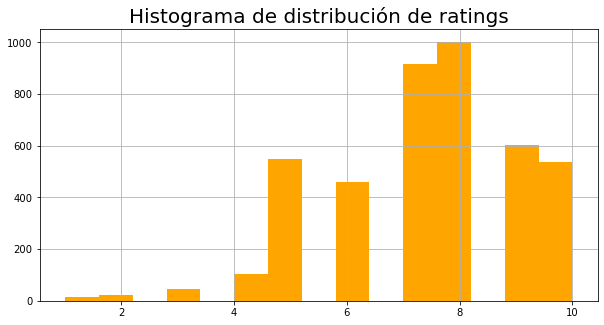

In [71]:
plt.figure(figsize=(10,5))
cf_data["Book-Rating"].hist(bins=15, color="orange")
plt.title("Histograma de distribución de ratings", fontsize=20)

In [72]:
reader = Reader(rating_scale=(1, 10))
data_ibf = Dataset.load_from_df(cf_data, reader)

In [73]:
cf_data.shape

(4253, 3)

### Modelo KNNWithMeans

In [74]:
# Create the trainset and testset
trainset = data_ibf.build_full_trainset()
testset = trainset.build_anti_testset() # https://ansegura7.github.io/RS_Surprise/pages/RS_SVD_Tune.html

In [75]:
#sim_options = {
#    "n_epochs": 10,
#    "lr_all": 0.002,
#    "reg_all": 0.02}

# Se entrena utilizando el modelo SVD y se hacen las predicciones para los pares (u,i) que NO están en el trainingset
#start = time.time()
#print("> Training...")

#algo = SVD(n_epochs = sim_options['n_epochs'],
#           lr_all = sim_options['lr_all'],
#           reg_all = sim_options['reg_all'])
#
# Train the algorithm on the trainset, and predict ratings for the testset
#algo.fit(trainset)

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
#predictions1 = algo.test(testset)

#end = time.time()
#print (">> DONE \t\t It Took", (end-start), "seconds" )

In [76]:
# Se entrena utilizando el modelo KNNWithMeans y se hacen las predicciones para los pares (u,i) que NO están en el trainingset
start = time.time()
print("> Training...")

sim_options = {
    "name":  "msd",
    "min_support": 6,
    "user_based": False
}

algorithm = KNNWithMeans(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
algorithm.fit(trainset)

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algorithm.test(testset)
print(f'MAE: {accuracy.mae(predictions)}, RMSE: {accuracy.rmse(predictions)}')

end = time.time()
print (">> DONE \t It Took", (end-start), "seconds")

> Training...
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  1.2980
RMSE: 1.6334
MAE: 1.2980015866825558, RMSE: 1.6333719749323292
>> DONE 	 It Took 110.4708571434021 seconds


In [77]:
matrix = pd.DataFrame(predictions)
matrix.rename(columns={"uid":"User-ID", "iid":"ISBN"}, inplace=True)
matrix.head(20)

,User-ID,ISBN,r_ui,est,details
0,15542,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}"
1,15542,8478886044,7.367505,8.000000,"{'actual_k': 0, 'was_impossible': False}"
2,15542,8420457477,7.367505,5.500000,"{'actual_k': 0, 'was_impossible': False}"
3,15542,8420636282,7.367505,9.333333,"{'actual_k': 0, 'was_impossible': False}"
4,15542,1400002672,7.367505,8.000000,"{'actual_k': 0, 'was_impossible': False}"
5,15542,8401462231,7.367505,8.285714,"{'actual_k': 0, 'was_impossible': False}"
6,15542,8408011200,7.367505,7.000000,"{'actual_k': 0, 'was_impossible': False}"
7,15542,8420789895,7.367505,10.000000,"{'actual_k': 0, 'was_impossible': False}"
8,15542,8423951537,7.367505,7.000000,"{'actual_k': 0, 'was_impossible': False}"
9,15542,8423970647,7.367505,3.000000,"{'actual_k': 0, 'was_impossible': False}"


In [78]:
matrix = matrix.merge(books[["ISBN", "Book-Title"]], on="ISBN")

In [3]:
matrix = pd.read_parquet("./predictions_matrix.parquet.gzip")
matrix.head()

,User-ID,ISBN,r_ui,est,details,Book-Title
0,15542,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra
1,184386,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra
2,276813,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra
3,276853,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra
4,14541,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra


In [79]:
matrix.head()

,User-ID,ISBN,r_ui,est,details,Book-Title
0,15542,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra
1,184386,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra
2,276813,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra
3,276853,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra
4,14541,8478442588,7.367505,7.333333,"{'actual_k': 0, 'was_impossible': False}",El Elogio de La Sombra


In [80]:
matrix.to_parquet("predictions_matrix.parquet.gzip", compression='gzip')

In [81]:
type(matrix["User-ID"][0])

str

In [ ]:
def recomendacion(user_id):
  registros = matrix[matrix["User-ID"] == user_id]
  registros = registros.sort_values("est", ascending=False).head(10)
  return registros

In [ ]:
def recommend_book(user_id):
    matrix = pd.read_parquet("predictions_matrix.parquet.gzip")
    print(matrix.head())
    registros = matrix[matrix["User-ID"] == user_id]
    registros = registros.sort_values("est", ascending=False).head(10)
    rec = registros.merge(books[["ISBN", "Book-Title"]], on="ISBN")
    books_rec = rec["Book-Title"].tolist()
    return {"Recommendation": books_rec}
recommend_book("244651")

In [ ]:
recomendacion("244651")

In [ ]:
data[data["User-ID"] == "32440"]

In [ ]:
data.shape

In [ ]:
data.dropna()